In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *
import os
import pandas as pd


# Problem & Dataset

* Chemistry is not a mostly loved subject.
* There are various chemical compounds. The problem here is to pronounce a common name knowing its formula.  
* So, we try to learn transition: molecular_formula->common_name.
* If you want, you can replace source and target variables to predict something else (sequential)

In [2]:
molecules = pd.read_csv('molecules.tsv', sep='\t', index_col=0)
molecules = molecules[["common_name", "molecular_formula"]]
molecules = molecules.dropna()
print(len(molecules))
molecules.head(5)

76049


,common_name,molecular_formula
0,Ethyl 3-ethoxy-2-nitroacrylate,C_{7}H_{11}NO_{5}
1,N-Butyl-3-(4-fluorophenyl)-1-phenyl-1H-pyrazol...,C_{20}H_{20}FN_{3}O
2,N-Butyl-N-sec-butyl-1-benzothiophene-3-carboxa...,C_{17}H_{23}NOS
3,2-{6-[(2S)-2-Butanyl]-2-(2-methyl-2-propanyl)-...,C_{21}H_{29}N_{5}O_{3}
4,"4-Bromo-5-[(3-hydroxy-2,3-dimethyl-2-butanyl)a...",C_{13}H_{22}BrN_{3}O_{2}


In [3]:
def get_xy(x, y):
    global molecules
    return x.values, y.apply(lambda s: ["START"]+list(s)+["END"])

source_seqs, target_seqs = get_xy(molecules.molecular_formula, molecules.common_name)

In [4]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print(source, ':', "".join(target[1:-1]))

C_{7}H_{11}NO_{5} : Ethyl 3-ethoxy-2-nitroacrylate
C_{20}H_{20}FN_{3}O : N-Butyl-3-(4-fluorophenyl)-1-phenyl-1H-pyrazole-5-carboxamide
C_{17}H_{23}NOS : N-Butyl-N-sec-butyl-1-benzothiophene-3-carboxamide
C_{21}H_{29}N_{5}O_{3} : 2-{6-[(2S)-2-Butanyl]-2-(2-methyl-2-propanyl)-5,8-dioxo-5,6,7,8-tetrahydro-4H-pyrazolo[1,5-a]pyrrolo[3,4-d]pyrimidin-4-yl}-N-cyclopropylacetamide
C_{13}H_{22}BrN_{3}O_{2} : 4-Bromo-5-[(3-hydroxy-2,3-dimethyl-2-butanyl)amino]-2-propyl-3(2H)-pyridazinone


In [5]:
print(type(source_seqs))

<class 'numpy.ndarray'>


In [6]:
target_letters = list(set([token for ts in target_seqs for token in ts]))
target_letter_to_ix = {ph: i for i, ph in enumerate(target_letters)}

In [7]:
source_letters = list(set([token for word in source_seqs for token in word]))
source_letter_to_ix = {l: i for i, l in enumerate(source_letters)}

150


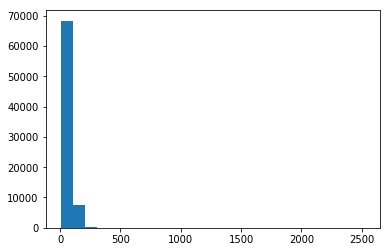

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len, target_seqs)), bins=25);

# Truncate names longer than MAX_LEN characters. This can be changed
MAX_LEN = min([150, max(list(map(len, target_seqs)))])
print(MAX_LEN)

### Cast everything from symbols into matrix of int32. Pad with -1

In [9]:
def as_matrix(sequences, token_to_i, max_len=None, PAX_ix=-1):
    """
    Converts several sequences of tokens to a matrix, edible a neural network.
    Crops at max_len(if given), pads shorter sequences with -1 or PAD_ix.
    """
    max_len = max_len or max(map(len, sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') -1
    for i, seq in enumerate(sequences):
        
        row_ix = [token_to_i.get(_, 0) for _ in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix


In [10]:
print(as_matrix(source_seqs[:3], source_letter_to_ix))

[[44 11 24 17  2 38 11 24  8  8  2 10 30 11 24 19  2 -1 -1]
 [44 11 24 43 41  2 38 11 24 43 41  2 40 10 11 24 25  2 30]
 [44 11 24  8 17  2 38 11 24 43 25  2 10 30 36 -1 -1 -1 -1]]


# Input variables

In [11]:
input_sequence = T.matrix('token sequence', 'int32')
target_sequence = T.matrix('target sequence', 'int32')

# Build NN

You will be building a model that takes token sequence and predicts next token


* Input sequence
* One-hot / embedding
* Encoder recurrent layer(s)
* Decoder recurrent layer(s)
* Softmax layer to predict probabilities

In [12]:
EMBEDDING_SIZE = 32
HIDDEN_SIZE = 64

##ENCODER
l_in = InputLayer(shape=(None, None), input_var=input_sequence)
l_mask = InputLayer(shape=(None, None), input_var=T.neq(input_sequence, -1)) 

l_emb = EmbeddingLayer(l_in, len(source_letters), EMBEDDING_SIZE)
l_rnn = LSTMLayer(l_emb, 
                  HIDDEN_SIZE, 
                  only_return_final=True, 
                  mask_input=l_mask, 
                  grad_clipping=5.)

In [13]:
##DECODER
dec_in = InputLayer(shape=(None, None), input_var=target_sequence)
dec_mask = InputLayer(shape=(None, None), input_var=T.neq(target_sequence, -1))

dec_emb = EmbeddingLayer(dec_in, len(target_letters), EMBEDDING_SIZE)
dec_rnn = LSTMLayer(dec_emb, 
                    HIDDEN_SIZE,
                    cell_init=l_rnn,
                    mask_input=dec_mask, 
                    grad_clipping=5.)
# WARNING! if it's lstm use cell_init, not hid_init


#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
dec_rnn_flat = reshape(dec_rnn, (-1, dec_rnn.output_shape[-1]))

decoder_flat = DenseLayer(dec_rnn_flat,
                          num_units=len(target_letters),
                          nonlinearity=lasagne.nonlinearities.softmax)

In [14]:
# Model weights
weights = get_all_params(decoder_flat, trainable=True)
#print weights

In [15]:
decoder = reshape(decoder_flat,
                  [target_sequence.shape[0], target_sequence.shape[1], -1])
#If you use dropout do not forget to create deterministic version for evaluation
decoder_output = get_output(decoder)

In [16]:
predictions_flat = decoder_output[:, :-1, :].reshape([-1, len(target_letters)])
targets = target_sequence[:, 1:].ravel()
targets_one_hot = lasagne.utils.one_hot(targets, len(target_letters))

#do not count loss for '-1' tokens
mask = T.neq(targets, -1).ravel()

loss = T.dot(mask, T.nnet.categorical_crossentropy(predictions_flat, targets_one_hot))/T.sum(mask)

updates = lasagne.updates.adam(loss, weights)

# Compiling it

In [17]:
#training
train = theano.function([input_sequence, target_sequence], 
                        loss, 
                        updates=updates, 
                        allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_sequence],
                               loss, 
                               allow_input_downcast=True)

# Generation

We now need to implement a function that generates output sequence given input.

Such function must work thusly:
```
Init:
x = input
y = ["START"]

While not_too_long:
  p(y_next|x,y) = probabilities of next letter for y
  
  y_next ~ p(y_next|x,y)
  
  y.append(y_next)
  
  if y_next == "END":
      break
```

In [18]:
#compile the function that computes probabilities for next token given previous text.
# <network output reshaped to [batch,tick,token] format>

# <a matrix [batch_i, decoder_n_tokens] of network output for last time step>
last_word_probas = decoder_output[:, -1, :]

# <a function that predicts probabilities coming after the last token>
probs = theano.function([input_sequence, target_sequence], 
                        last_word_probas,
                        allow_input_downcast=True)

In [19]:
def generate_output(seq_in,
                    output_prefix = ("START",),
                    END_token="END",
                    temperature=1,
                    sample=True):
    
    """
    Implement a function that generates output sequence given input.
    
    We recommend (but not require) you to use the pseudo-code above and inline instructions.
    """
    
    output = list(output_prefix)
    
    while True:
        next_y_probs = probs(as_matrix([seq_in], source_letter_to_ix), 
                             as_matrix([output], target_letter_to_ix))
        next_y_probs = next_y_probs**(1/temperature)
        next_y_probs = next_y_probs/np.sum(next_y_probs)

        if sample:
            next_y = np.random.choice(target_letters, p=next_y_probs[0])
        else:
            next_y = target_letters[np.argmax(next_y_probs[0])]
        
        next_y = str(next_y)
        assert type(next_y) is str, "please return token(string/character), not it's index"
        
        output.append(next_y)

        if next_y == END_token:
            break
            
    return output



# Model training

In [20]:
source_seqs = np.array(source_seqs)
target_seqs = np.array(target_seqs)

In [ ]:
def sample_batch(source_seqs, target_seqs, batch_size):
    """samples a random batch of source and target sequences, batch_size elements"""
    batch_ix = np.random.randint(0, len(source_seqs), size=batch_size)
    source_seqs_batch=as_matrix(source_seqs[batch_ix], source_letter_to_ix) 
    target_seqs_batch=as_matrix(target_seqs[batch_ix], target_letter_to_ix)
    
    return source_seqs_batch, target_seqs_batch

In [ ]:
from tqdm import tqdm_notebook

#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in tqdm_notebook(range(n_epochs)):


    avg_cost = 0;
    
    for _ in tqdm_notebook(range(batches_per_epoch)):
        
        x, y = sample_batch(source_seqs, target_seqs, batch_size)
        avg_cost += train(x, y).mean()
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
    for i in range(5):
        ind = np.random.randint(len(source_seqs))
        print(source_seqs[ind], ':')
        print(''.join(generate_output(source_seqs[ind], sample=True)[1:-1]))



Epoch 0 average loss = 2.737534108818424
C_{24}H_{28}N_{4}O_{5} :
N-(4S-hetarroamenyr-2-(5-pemibonyl-9Hpyrmutnylbo4-[2]smuamop-zenzoxyl)[2)ipmolfolo-4pyra1amidanod]o-3-adinolacroacylyn}-betlinanenydibidiquol6am
C_{14}H_{18}ClNO_{3}S :
3-([1-2,Axpeta 4-N-h-minerro-1]enaln-pyl)-4-(,3[3,bo{2-menbaxoxo-4-1-yl]2-dino-dihaatlolocetyl)hanamime
C_{14}H_{16}N_{4}O_{3} :
M(6,3-(3-B-3-hethoxeyn]{N-5,2-zelyl)-3-N-2-s
C_{22}H_{16}N_{2}O_{6} :
3-[3-{(3-(fmethy-3S-{4-(-3-methyl]-3Hethyl)-2-[3-(4H-broploneno]-1-1-nyrol)petuylbe
C_{14}H_{18}ClNO_{2} :
3-,N-R[3-Ey1]-Bennylethyl)3-(4-3H-methyr-2-phunoxylaminocy]bethylzox-2,,1]bfzenalophoabul]ulxenei6itlopide


In [ ]:
"".join(generate_output("C_{7}H_{11}NO_{5}", temperature=2)[1:-1])

## Homework part 2 - chemistry (6 pt total)

* [4pts] Complete notebook and make sure target sequence is being generated.
* [2pts] Modify train cycle to output sequences with different sampling strategies (varying t in range $[0, + \infty)$ and try to find out which sampling strategy is the best for current task)


## [bonus] [2pts]  Latex display
Swap target and source and learn name->formula, then try to reach quality when almos any generated sequence is a valid Latex formula and implement its prinitng using IPython magic in jupyter. It would be good if you create a demo and pass there some chemical (or not?) names

In [ ]:
import IPython
z = IPython.display.Latex(data='$2+2$')
IPython.display.display(z)

# And now,
* try lstm/gru
* try several layers
* try mtg cards
* try your own dataset of any kind

In [ ]:
x = T.arange(-1,9)

In [ ]:
x.eval()

In [ ]:
lasagne.utils.one_hot(x, 10).eval()